In [19]:
import pandas as pd
import matplotlib.pyplot as plt

#filepath variable
csv_loc = "c:/Users/gspah/Desktop/MSU_Data_bootcamp/pandas_challenge/pymoli/purchase_data.csv"

#read csv and create data frame
purch_df = pd.read_csv(csv_loc)


In [20]:
#variable players should contain the length of the column of user names, with only unique values
#this gives the total number of players

players = len(pd.unique(purch_df["SN"]))

#output statement
print("The numeber of unique players who have made a purchase is: " + str(players))

The numeber of unique players who have made a purchase is: 576


In [21]:
#Basic Metrics
#number of unique items
uniq_it = purch_df[["Item Name", "Price"]].copy()                   #dataframe for just items and prices .copy() is added  
                                                                    #to clear up the SettingWithCopyWarning
uniq_it.drop_duplicates(subset = "Item Name", inplace = True)       #This operation drops duplicate sales

uniq_it_num = len(uniq_it)

#average price
price = round(uniq_it["Price"].mean(), 2)                           # .mean() and .sum() are used to compute properties of
                                                                    # columns in DataFrame["column"] 
pr_disp = "$" + str(price)

#total revenue
tot_rev = purch_df["Price"].sum()

rev_d = "$" + str(tot_rev)

#number of purchase
purch_no = len(purch_df)

#basic stats dataframe: dataframe is created from a dictionary of dict = {"column": [val1, val2, ... valn]}

bsc_stat = {"Unique Items": [uniq_it_num], "Average Price": [pr_disp], "Number of Purchases": [purch_no], "Total Revenue": [rev_d]}

bsc_stat_df = pd.DataFrame(bsc_stat, columns =["Unique Items", "Average Price", "Number of Purchases", "Total Revenue"])

#finished dataframe
bsc_stat_df

,Unique Items,Average Price,Number of Purchases,Total Revenue
0,179,$3.04,780,$2379.77


In [22]:
#gender demographics
uniq_users = purch_df[["SN", "Age", "Gender"]].copy()         #copy data from purch_df into new dataframe
uniq_users.drop_duplicates(subset = "SN", inplace = True)     # drop duplicates to get unique user data

g_count = uniq_users["Gender"].value_counts()                 # g_count is a series of indexed counts of genders

#this returns a series with percents for male, female and other in that order
perc = (g_count/players)*100

#this section converts perc and g_count to dataframes
#g_count is renamed so I can call from that series in the next analysis
perc = perc.to_frame().reset_index()

count = g_count.to_frame().reset_index()

#this section is to merge the two frames into a single dataframe

gndr_stats = pd.merge(count, perc, on= "index")

#This will rename the columns

gndr_stats = gndr_stats.rename(columns = {"index":"Gender", "Gender_x":"Count", "Gender_y":"Percent of Players"})

#formatting section

gndr_stats["Percent of Players"] = gndr_stats["Percent of Players"].map("{:.2f}%".format)

gndr_stats = gndr_stats.set_index("Gender")

#Finished dataframe
gndr_stats

,Count,Percent of Players
Gender,,
Male,484,84.03%
Female,81,14.06%
Other / Non-Disclosed,11,1.91%


In [23]:
#gender revenue analysis
#groupby gender for the original dataframe

#first I'm making a copy dataframe with the revenue data 
gen_purch_df = purch_df[["Gender", "Price"]].copy()

#group by gender and display average price per gender per purchase
ave_pur_price = gen_purch_df.groupby("Gender").mean()

ave_pur_price = ave_pur_price.rename(columns = {"Price":"Ave Purchase Price"})

#group by gender and display the sum of purchases per gender
gen_tot_rev = gen_purch_df.groupby("Gender").sum()

gen_tot_rev = gen_tot_rev.rename(columns = {"Price":"Total Revenue"})

#groupby gender and count the purchases for each gender
gen_purch_ct = gen_purch_df.groupby("Gender").count()

gen_purch_ct = gen_purch_ct.rename(columns = {"Price":"Purchase Count"})

#This line calculates average spending by gender and returns a series

av_g_sp = gen_tot_rev["Total Revenue"]/gndr_stats["Count"]

#Now I will make av_g_sp into a dataframe

av_g_sp = av_g_sp.to_frame().reset_index()

#rename column 2

av_g_sp = av_g_sp.rename(columns = {0:"Average Total Purchase"})

#merging dataframes created by groupby operations into one dataframe
#this required 3 steps to do - it doesn't seem like you can merge multiple frames at once

m1 = pd.merge(gen_purch_ct, av_g_sp, on = "Gender")

m2 = pd.merge(ave_pur_price, gen_tot_rev, on = "Gender")

gender_stats = pd.merge(m1, m2, on = "Gender")

#formatting the dataframe

gender_stats["Average Total Purchase"] = gender_stats["Average Total Purchase"].map("${:.2f}".format)
gender_stats["Total Revenue"] = gender_stats["Total Revenue"].map("${:.2f}".format)
gender_stats["Ave Purchase Price"] = gender_stats["Ave Purchase Price"].map("${:.2f}".format)

gender_stats = gender_stats.set_index("Gender")

#finished dataframe
gender_stats

,Purchase Count,Average Total Purchase,Ave Purchase Price,Total Revenue
Gender,,,,
Female,113,$4.47,$3.20,$361.94
Male,652,$4.07,$3.02,$1967.64
Other / Non-Disclosed,15,$4.56,$3.35,$50.19


In [24]:
#age bin analysis
#in this cell I will bin purch_df then drop duplicates under a different name

ages = [5, 9, 14, 19, 24, 29, 34, 39, 45]

ag_bn = ["< 10", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40+"]

purch_df["age_bin"] = pd.cut(purch_df["Age"], ages, labels = ag_bn, include_lowest = True)

#ab_df is my dataframe for age analysis. I'm dropping duplicates from it so I get a picture of users, not purchases
ab_df = purch_df[["SN", "age_bin"]].copy()
ab_df.drop_duplicates(subset = "SN", inplace = True)

ab_df = ab_df.groupby("age_bin").count()

ab_df = ab_df.rename(columns = {"SN":"Count"})

#I will use a list comprehension to calculate and format percentages

age_prcnt = [str(round((count/players)*100, 2)) + "%" for count in ab_df["Count"]]

#I'm now making that list into a dictionary so I can define a new dataframe to merge with ag_bn

age_prcnt_d = {"age_bin":ag_bn, "Percentages":age_prcnt}

age_prcnt_df = pd.DataFrame(age_prcnt_d, columns = ["age_bin", "Percentages"])

age_anl = pd.merge(ab_df, age_prcnt_df, on = "age_bin")

age_anl = age_anl.set_index('age_bin')

#finished dataframe
age_anl

,Count,Percentages
age_bin,,
< 10,17,2.95%
10-14,22,3.82%
15-19,107,18.58%
20-24,258,44.79%
25-29,77,13.37%
30-34,52,9.03%
35-39,31,5.38%
40+,12,2.08%


In [25]:
#age bin revenue analysis
#to start the I will use the purch_df dataframe to make a new frame for analysis, absent unneccesary data

pur_age = purch_df[["age_bin", "Price"]].copy()

#total revenue by age bin

rev_age_bin = pur_age.groupby("age_bin").sum()

#average purchase price by agebin

avpr_ab = pur_age.groupby("age_bin").mean()

#purchase count by age bin

ctpr_ab = pur_age.groupby("age_bin").count()

#this will calculate the average expendature per person and put it in a new data frame

a_t_p_p = rev_age_bin["Price"]/ab_df["Count"]

#I figured out that the operation above returned a series. I had to convert that to a dataframe to manipulate it
# as I desired. The code to do the conversion is in the line below. 

a_t_p_p = a_t_p_p.to_frame().reset_index()

#this is a section for renameing columns

rev_age_bin = rev_age_bin.rename(columns = {"Price":"Total Revenue"})

avpr_ab = avpr_ab.rename(columns = {"Price":"Average Purchase Price"})

ctpr_ab = ctpr_ab.rename(columns = {"Price":"Purchase Count"})

a_t_p_p = a_t_p_p.rename(columns = {0:"Average Revenue per Person"})

#This is for merging the results into a single dataframe

u1 = pd.merge(rev_age_bin, a_t_p_p, on = "age_bin")

u2 = pd.merge(ctpr_ab, avpr_ab, on = "age_bin")

full_age_an = pd.merge(u2, u1, on = "age_bin")

#formatting the finished dataframe

full_age_an["Average Purchase Price"] = full_age_an["Average Purchase Price"].map("${:.2f}".format)
full_age_an["Total Revenue"] = full_age_an["Total Revenue"].map("${:.2f}".format)
full_age_an["Average Revenue per Person"] = full_age_an["Average Revenue per Person"].map("${:.2f}".format)

full_age_an = full_age_an.set_index("age_bin")

#Finished dataframe with the desired information
full_age_an

,Purchase Count,Average Purchase Price,Total Revenue,Average Revenue per Person
age_bin,,,,
< 10,23,$3.35,$77.13,$4.54
10-14,28,$2.96,$82.78,$3.76
15-19,136,$3.04,$412.89,$3.86
20-24,365,$3.05,$1114.06,$4.32
25-29,101,$2.90,$293.00,$3.81
30-34,73,$2.93,$214.00,$4.12
35-39,41,$3.60,$147.67,$4.76
40+,13,$2.94,$38.24,$3.19


In [26]:
#high roller analysis
#1st step: make the dataframe for analysis

hi_roll = purch_df[["SN", "Price"]].copy()

#purchase count analysis

hr_pct = hi_roll.groupby("SN").count()

hr_pct = hr_pct.rename(columns = {"Price": "Count"})


#total revenue analysis

hr_rev = hi_roll.groupby("SN").sum()

hr_rev = hr_rev.rename(columns = {"Price":"Total Spending"})


#average purchase price by user

hr_ave = hi_roll.groupby("SN").mean()

hr_ave = hr_ave.rename(columns = {"Price": "Average Price"})


#I am now going to merge the frames together and sort by total spending

u3 = pd.merge(hr_pct, hr_ave, on = "SN")

hi_roll_df = pd.merge(u3, hr_rev, on = "SN")

hi_roll_df = hi_roll_df.sort_values(by = ["Total Spending"], ascending = False)


#in order to only see the top five I'm making a copy of the view returned by the .head() command

hi_roll_df_clip = hi_roll_df.head().copy()

#formatting section

hi_roll_df_clip["Average Price"] = hi_roll_df_clip["Average Price"].map("${:.2f}".format)

hi_roll_df_clip["Total Spending"] = hi_roll_df_clip["Total Spending"].map("${:.2f}".format)

#finished dataframe
hi_roll_df_clip

,Count,Average Price,Total Spending
SN,,,
Lisosia93,5,$3.79,$18.96
Idastidru52,4,$3.86,$15.45
Chamjask73,3,$4.61,$13.83
Iral74,4,$3.40,$13.62
Iskadarya95,3,$4.37,$13.10


In [27]:
#This analysis is for most popular items

popit_df = purch_df[["Item Name", "Price"]].copy()

popit_ct = popit_df.groupby("Item Name").count()

#This groupby is to get total revenue for each item

popit_tot = popit_df.groupby("Item Name").sum()

popit_ave = popit_df.groupby("Item Name").mean()

#now I need to rename all my columns

popit_ct = popit_ct.rename(columns = {"Price":"Sale Count"})

popit_tot = popit_tot.rename(columns = {"Price": "Sales Revenue"})

#merge the groupby dataframes into one

u4 = pd.merge(popit_ct, popit_tot, on = "Item Name")

popit_fin = pd.merge(popit_ave, u4, on = "Item Name")

#sort the data by sale count and port the top 6 rows into a table

popit_fin = popit_fin.sort_values(by = ["Sale Count"], ascending = False)

popit_sumry = popit_fin.head(6).copy()

#formatting section

popit_sumry["Price"] = popit_sumry["Price"].map("${:.2f}".format)
popit_sumry["Sales Revenue"] = popit_sumry["Sales Revenue"].map("${:.2f}".format)

#finished dataframe
popit_sumry

,Price,Sale Count,Sales Revenue
Item Name,,,
Final Critic,$4.61,13,$59.99
"Oathbreaker, Last Hope of the Breaking Storm",$4.23,12,$50.76
Persuasion,$3.22,9,$28.99
Nirvana,$4.90,9,$44.10
"Extraction, Quickblade Of Trembling Hands",$3.53,9,$31.77
Fiery Glass Crusader,$4.58,9,$41.22


In [28]:
#profitable items analysis
#The last table is exactly like the penultimate one - just resorted for maximal sales revenue

profit_df = popit_fin.sort_values(by = ["Sales Revenue"], ascending = False)

profit_sumry = profit_df.head(6).copy()

#formatting section

profit_sumry["Price"] = profit_sumry["Price"].map("${:.2f}".format)
profit_sumry["Sales Revenue"] = profit_sumry["Sales Revenue"].map("${:.2f}".format)

#finished dataframe
profit_sumry

,Price,Sale Count,Sales Revenue
Item Name,,,
Final Critic,$4.61,13,$59.99
"Oathbreaker, Last Hope of the Breaking Storm",$4.23,12,$50.76
Nirvana,$4.90,9,$44.10
Fiery Glass Crusader,$4.58,9,$41.22
Singed Scalpel,$4.35,8,$34.80
"Lightning, Etcher of the King",$4.23,8,$33.84


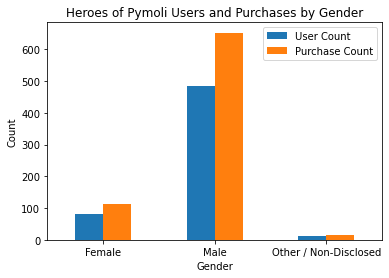

In [82]:
#Gender and Purchase Histogram

#here I'm cleaning up the labels of a dataframe for plotting
count = count.rename(columns ={"index":"Gender", "Gender":"User Count"})

#I had to sort here, because the Genders were in different orders in the two dataframes I plotted
count = count.sort_values(by = ["Gender"])

#merging 2 frames of interest for ease of plotting
histo0 = pd.merge(count, gen_purch_ct, on = "Gender")

#rendering and configuring the plot using pandas and matplotlib functions
histo0.plot(kind = 'bar', rot = 0)

plt.ylabel("Count")

plt.title("Heroes of Pymoli Users and Purchases by Gender")

#export to image file
plt.savefig('c:/Users/gspah/Desktop/MSU_Data_bootcamp/pandas_challenge/pymoli/Pymoli_gender_hist.png')



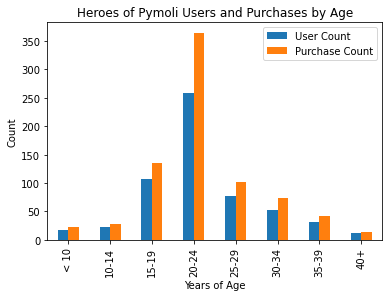

In [83]:
#age and purcase histogram

#cleaning up labels
ab_df = ab_df.rename(columns = {"Count":"User Count"})

#merging for ease of plotting
histo1 = pd.merge(ab_df, ctpr_ab, on = "age_bin")

histo1.plot(kind = 'bar')

plt.ylabel('Count')

plt.xlabel('Years of Age')

plt.title('Heroes of Pymoli Users and Purchases by Age')

#export to image file
plt.savefig('c:/Users/gspah/Desktop/MSU_Data_bootcamp/pandas_challenge/pymoli/Pymoli_age_hist.png')

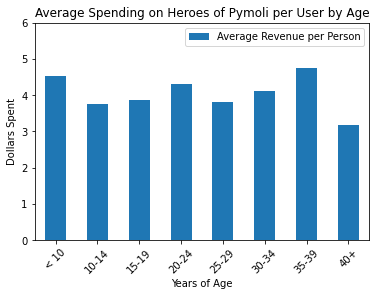

In [84]:
#Average Spending per agegroup 

a_t_p_p.plot(kind = "bar", ylim = (0, 6), rot = 45)

plt.xlabel('Years of Age')
plt.ylabel('Dollars Spent')
plt.title('Average Spending on Heroes of Pymoli per User by Age')

#export to image file
plt.savefig('c:/Users/gspah/Desktop/MSU_Data_bootcamp/pandas_challenge/pymoli/Pymoli_age_spending.png')

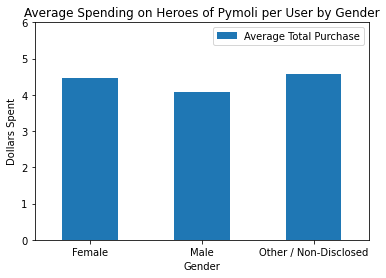

In [85]:
#average spending per gender

av_g_sp.plot(kind = "bar", ylim = (0, 6), rot = 0)

plt.ylabel('Dollars Spent')
plt.title('Average Spending on Heroes of Pymoli per User by Gender')

#export to image file
plt.savefig('c:/Users/gspah/Desktop/MSU_Data_bootcamp/pandas_challenge/pymoli/Pymoli_gender_spending.png')

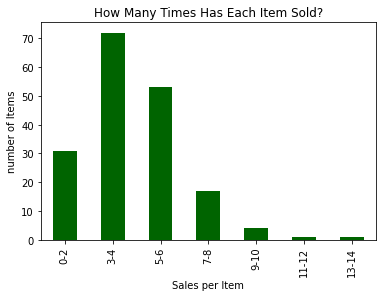

In [96]:
#Item Sales Histogram

#binning items
sbin = [0, 2, 4, 6, 8, 10, 12, 14]

slabel = ["0-2", "3-4", "5-6", "7-8", "9-10", "11-12", "13-14"]

#adding bins to a df with sales count information
popit_ct["Sales Bin"] = pd.cut(popit_ct["Sale Count"], sbin, labels = slabel, include_lowest = True)

#grouping by count bins
popit_hist = popit_ct.groupby("Sales Bin").count()

#plotting and formatting the plot
popit_hist.plot(kind = "bar", color = "darkgreen", legend = False)

plt.xlabel('Sales per Item')
plt.ylabel('number of Items')
plt.title('How Many Times Has Each Item Sold?')

#export to image file
plt.savefig('c:/Users/gspah/Desktop/MSU_Data_bootcamp/pandas_challenge/pymoli/item_sales.png')

In [100]:
#quick calculation to see the combined revenue of the most profitable items
top6 = profit_df.head(6).sum()

print(top6)

Price             26.904615
Sale Count        59.000000
Sales Revenue    264.710000
dtype: float64
